# Marketing ROI – Exploratory Data Analysis

## 1. Business Context

## 2. Data Overview

In [1]:
# Package and data import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

df = pd.read_csv("data/raw/marketing_roi_dataset.csv", parse_dates=["date"])
df.head()

,date,google_ads_spend,facebook_ads_spend,email_marketing_spend,influencer_spend,organic_traffic,email_sends,site_visits,conversions,revenue
0,2024-01-01,287.241527,38.751217,83.458307,56.837735,4284.075974,20833.136195,15852.676595,910.435777,-8969.378951
1,2024-01-02,179.335768,140.549719,NaN,20.403910,5547.499386,24988.993202,37961.341321,1271.621378,4996.218917
2,2024-01-03,165.874030,159.783970,15.718533,31.799587,1346.412153,24788.546292,37498.939314,817.848802,4703.488945
3,2024-01-04,165.876275,36.386370,35.434882,8.369025,6225.962257,11454.994399,36641.290979,1204.408229,1857.547269
4,2024-01-05,557.965729,116.865127,8.933307,264.236853,6723.641641,31469.636402,32982.737989,1315.849949,7763.494686


Although traffic and conversion metrics are typically integer-valued, they appear as continuous variables due to aggregation and attribution processes. For modeling purposes, these variables are treated as continuous.

In [2]:
# Schema and summary information

df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1000 non-null   datetime64[ns]
 1   google_ads_spend       950 non-null    float64       
 2   facebook_ads_spend     950 non-null    float64       
 3   email_marketing_spend  950 non-null    float64       
 4   influencer_spend       950 non-null    float64       
 5   organic_traffic        950 non-null    float64       
 6   email_sends            950 non-null    float64       
 7   site_visits            950 non-null    float64       
 8   conversions            950 non-null    float64       
 9   revenue                1000 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 78.2 KB


,count,mean,min,25%,50%,75%,max,std
date,1000,2025-05-14 12:00:00,2024-01-01 00:00:00,2024-09-06 18:00:00,2025-05-14 12:00:00,2026-01-19 06:00:00,2026-09-26 00:00:00,NaN
google_ads_spend,950.0,278.538146,5.510277,123.474699,210.754128,336.692252,7006.077877,375.215794
facebook_ads_spend,950.0,195.406462,2.327444,90.404891,159.483845,244.331656,2425.053989,179.329445
email_marketing_spend,950.0,58.835908,0.211186,25.021036,47.236664,82.127735,373.804054,46.906342
influencer_spend,950.0,85.66024,0.330408,28.510643,60.250737,120.089852,703.641999,80.610073
organic_traffic,950.0,4995.960394,396.013342,4151.292379,4970.314892,5869.920258,9052.859503,1269.97673
email_sends,950.0,20152.623976,4870.371191,16237.509366,20127.415054,23999.796429,38946.627698,5880.954234
site_visits,950.0,29894.592065,-1379.202013,24752.712408,30076.992579,35000.599413,53312.873726,7726.449355
conversions,950.0,1189.714006,187.32627,994.139269,1179.003079,1396.858054,2040.411897,292.442587
revenue,1000.0,2433.043276,-16329.076524,-916.706634,2421.080779,5894.710904,31589.536448,5309.341622


## 3. Data Quality Checks

In [3]:
# Date range

df["date"].min(), df["date"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2026-09-26 00:00:00'))

In [4]:
# Time series logic

df["date"].is_monotonic_increasing

True

## 4. Missing Data Analysis

In [5]:
# Missing value percentage

missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct

google_ads_spend         0.05
facebook_ads_spend       0.05
email_marketing_spend    0.05
influencer_spend         0.05
organic_traffic          0.05
email_sends              0.05
site_visits              0.05
conversions              0.05
date                     0.00
revenue                  0.00
dtype: float64

<Axes: title={'center': 'Weekly Missingness Rate by Feature'}, xlabel='date'>

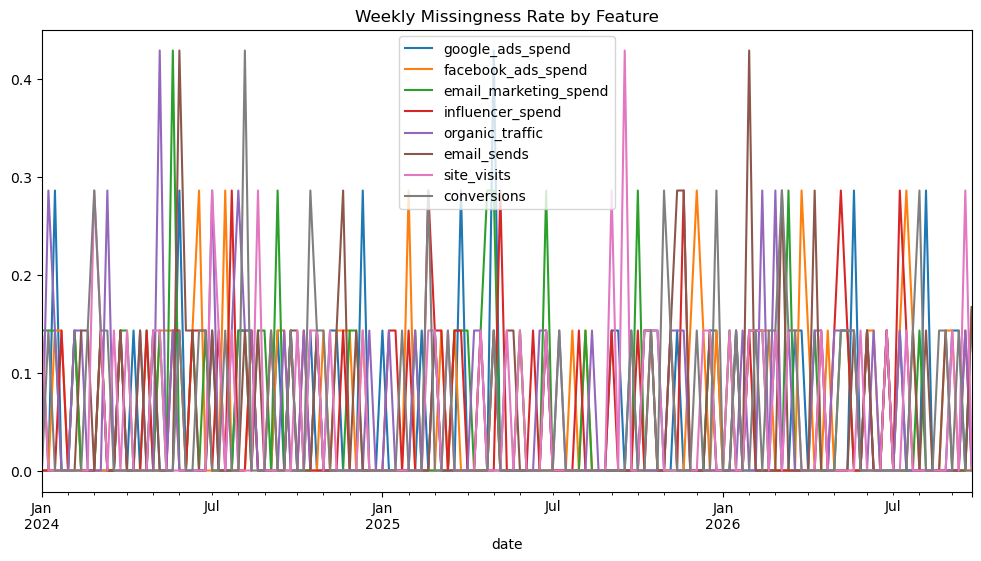

In [6]:
df["date"] = pd.to_datetime(df["date"])

missing_by_week = (
    df.set_index("date")
      .drop(columns=["revenue"])
      .isna()
      .resample("W")
      .mean()
)

missing_by_week.plot(
    figsize=(12, 6),
    title="Weekly Missingness Rate by Feature"
)

In [7]:
predictor_cols = df.columns.difference(["date", "revenue"])

for col in predictor_cols:
    df[f"{col}_missing"] = df[col].isna().astype(int)

In [8]:
missing_indicator_cols = [c for c in df.columns if c.endswith("_missing")]

missing_revenue_corr = (
    df[missing_indicator_cols]
    .corrwith(df["revenue"])
    .sort_values(ascending=False)
)

missing_revenue_corr

site_visits_missing              0.031137
conversions_missing             -0.000944
email_sends_missing             -0.005831
facebook_ads_spend_missing      -0.032105
email_marketing_spend_missing   -0.035073
influencer_spend_missing        -0.037237
google_ads_spend_missing        -0.061315
organic_traffic_missing         -0.075387
dtype: float64

In [9]:
df["google_ads_spend_missing"] = df["google_ads_spend"].isna()

df.groupby("google_ads_spend_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
google_ads_spend_missing,,,,,,,,
False,950.0,2507.690983,5316.475060,-16329.076524,-882.122410,2445.927075,5956.846724,31589.536448
True,50.0,1014.736840,5013.551481,-10644.721570,-2087.921752,1728.390582,4079.443353,16490.909460


In [10]:
df["facebook_ads_spend_missing"] = df["facebook_ads_spend"].isna()

df.groupby("facebook_ads_spend_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
facebook_ads_spend_missing,,,,,,,,
False,950.0,2472.129140,5284.286701,-16329.076524,-905.327465,2421.080779,5906.490269,31589.536448
True,50.0,1690.411853,5771.702615,-13879.303153,-1571.191969,2257.028541,5496.025743,18926.837563


In [11]:
df["email_marketing_spend_missing"] = df["email_marketing_spend"].isna()

df.groupby("email_marketing_spend_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
email_marketing_spend_missing,,,,,,,,
False,950.0,2475.742012,5236.427842,-15502.115057,-906.412479,2421.080779,5923.304738,31589.536448
True,50.0,1621.767280,6553.595916,-16329.076524,-2046.624373,2178.850931,5338.660818,23152.037956


In [12]:
df["influencer_spend_missing"] = df["influencer_spend"].isna()

df.groupby("influencer_spend_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
influencer_spend_missing,,,,,,,,
False,950.0,2478.377423,5288.794555,-16329.076524,-897.890949,2442.711901,5937.295268,31589.536448
True,50.0,1571.694468,5673.176653,-10890.710414,-2071.873636,1678.920461,5030.612725,14663.353304


In [13]:
df["organic_traffic_missing"] = df["organic_traffic"].isna()

df.groupby("organic_traffic_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
organic_traffic_missing,,,,,,,,
False,950.0,2524.822682,5330.149648,-16329.076524,-882.122410,2442.711901,5978.696218,31589.536448
True,50.0,689.234552,4605.483898,-9281.783989,-1859.665852,1439.266209,4029.206762,8708.401561


In [14]:
df["email_sends_missing"] = df["email_sends"].isna()

df.groupby("email_sends_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
email_sends_missing,,,,,,,,
False,950.0,2440.142729,5337.592227,-16329.076524,-912.739971,2419.153141,5883.905687,31589.536448
True,50.0,2298.153653,4787.431166,-8504.839138,-1176.279881,2589.384572,5905.420411,10923.915517


In [15]:
df["site_visits_missing"] = df["site_visits"].isna()

df.groupby("site_visits_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
site_visits_missing,,,,,,,,
False,950.0,2395.136182,5309.677421,-15502.115057,-1007.101885,2418.183532,5854.866851,31589.536448
True,50.0,3153.278057,5304.540641,-16329.076524,281.190168,3005.760959,6517.814338,15686.515783


In [16]:
df["conversions_missing"] = df["conversions"].isna()

df.groupby("conversions_missing")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
conversions_missing,,,,,,,,
False,950.0,2434.192615,5273.76806,-15502.115057,-920.441762,2419.153141,5868.190895,31589.536448
True,50.0,2411.205822,6004.60506,-16329.076524,-882.122410,3013.235417,6300.901580,15686.515783


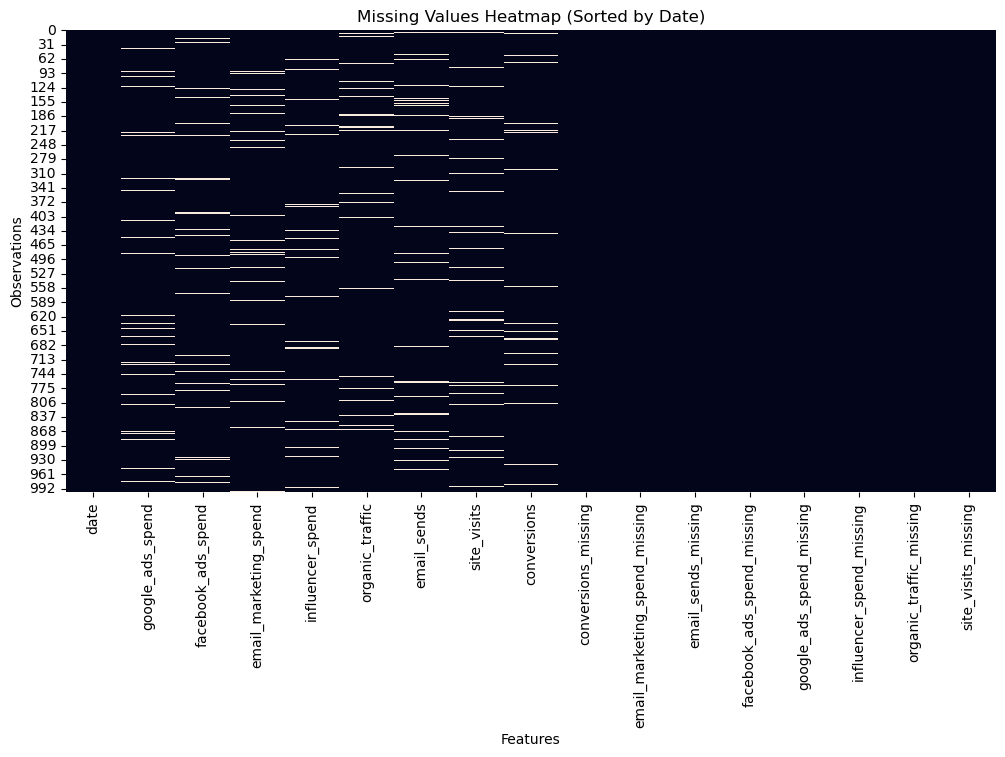

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    df.sort_values("date")
      .drop(columns=["revenue"])
      .isna(),
    cbar=False
)

plt.title("Missing Values Heatmap (Sorted by Date)")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

Approximately 5% of values are missing across predictor variables, while date and revenue contain no missing values. Missingness was analyzed temporally and conditionally and found to be informative rather than completely random. To preserve signal and avoid bias, missing value indicators were added and median imputation was applied prior to modeling.


## 5. Distribution Analysis

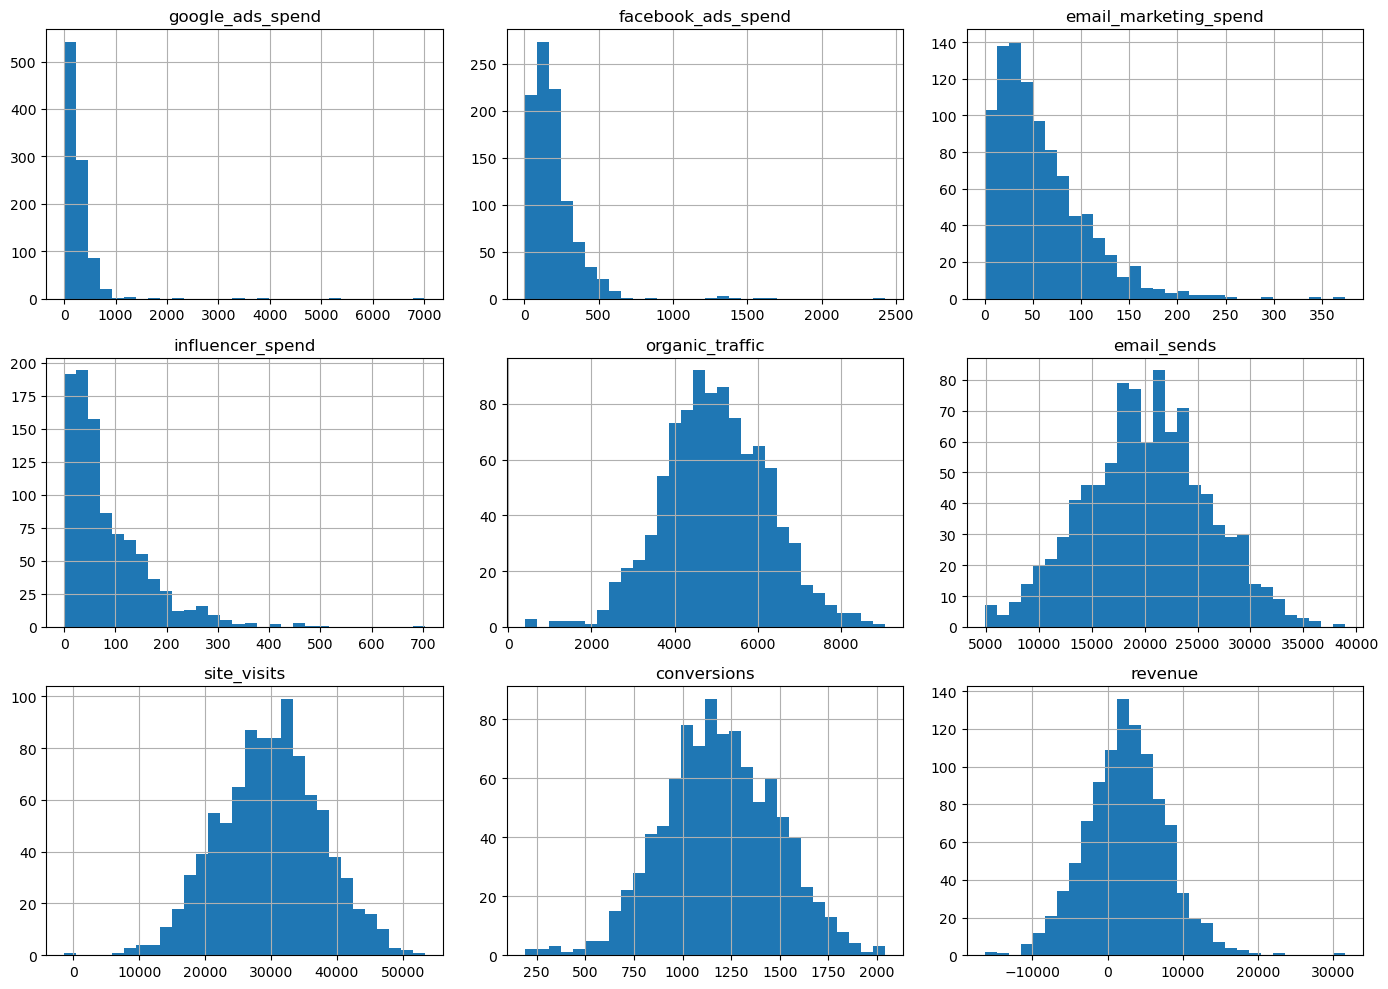

In [18]:
# Distribution of variables

numeric_cols = df.select_dtypes(include="number").columns

df[numeric_cols].hist(figsize=(14,10), bins=30)
plt.tight_layout()
plt.show()

Several input variables exhibited strong right skew, typical of spend and traffic data. These features will be log-transformed using log1p to stabilize variance and improve linearity. All transformed variables will then be standardized to enable coefficient comparability in downstream regression models.

## 6. Outlier Exploration

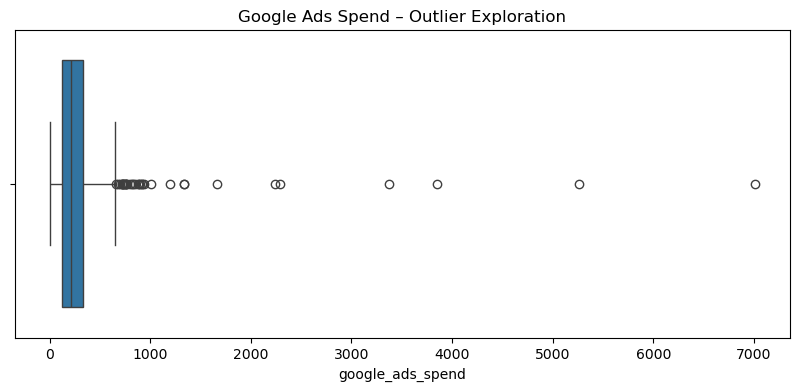

In [19]:
# Google ads outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["google_ads_spend"])
plt.title("Google Ads Spend – Outlier Exploration")
plt.show()

In [20]:
# Google ads distribution data

df["google_ads_spend"].quantile([0.95, 0.99])

0.95     610.962001
0.99    1106.860940
Name: google_ads_spend, dtype: float64

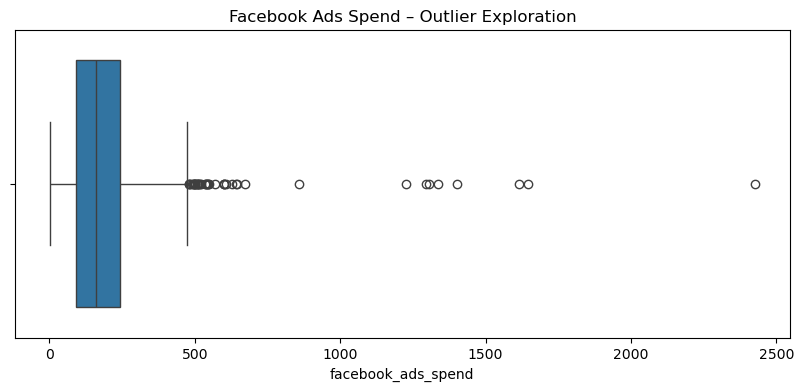

In [21]:
# Facebook ads outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["facebook_ads_spend"])
plt.title("Facebook Ads Spend – Outlier Exploration")
plt.show()

In [22]:
# Facebook ads distribution data

df["facebook_ads_spend"].quantile([0.95, 0.99])

0.95    459.736920
0.99    659.007301
Name: facebook_ads_spend, dtype: float64

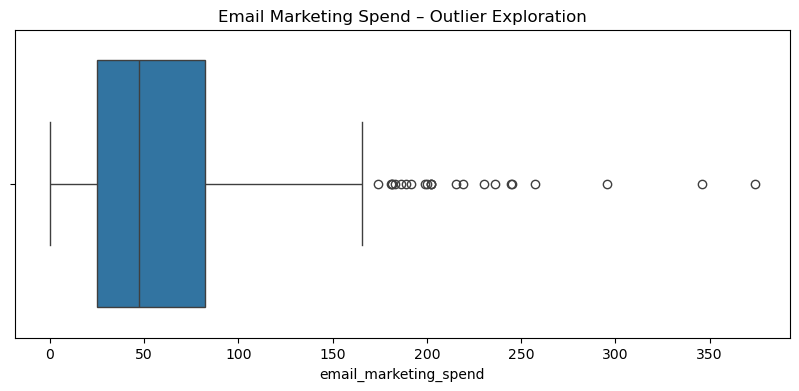

In [23]:
# Email marketing outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["email_marketing_spend"])
plt.title("Email Marketing Spend – Outlier Exploration")
plt.show()

In [24]:
# Email marketing distribution data

df["email_marketing_spend"].quantile([0.95, 0.99])

0.95    144.738148
0.99    208.931629
Name: email_marketing_spend, dtype: float64

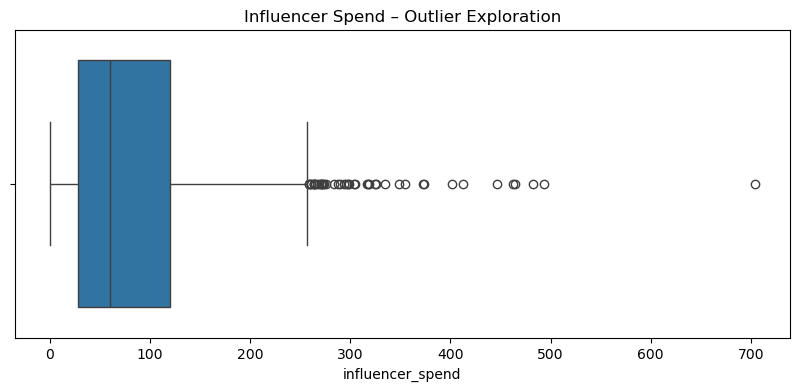

In [25]:
# Influencer outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["influencer_spend"])
plt.title("Influencer Spend – Outlier Exploration")
plt.show()

In [26]:
# Influencer spend distribution data

df["influencer_spend"].quantile([0.95, 0.99])

0.95    251.037978
0.99    363.730644
Name: influencer_spend, dtype: float64

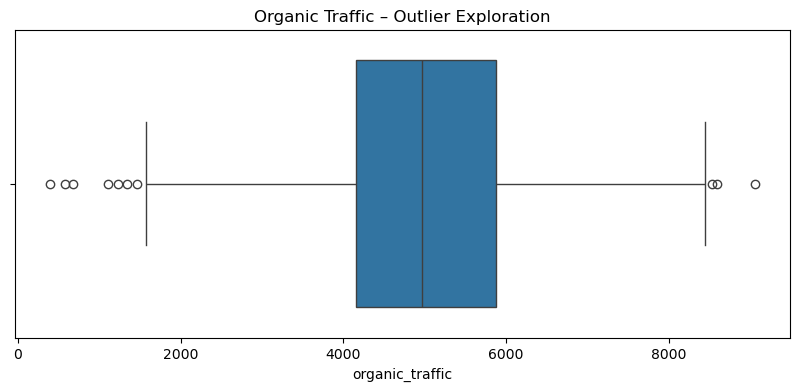

In [27]:
# Organic Traffic outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["organic_traffic"])
plt.title("Organic Traffic – Outlier Exploration")
plt.show()

In [28]:
# Organic Traffic distribution data

df["organic_traffic"].quantile([0.95, 0.99])

0.95    7041.183824
0.99    8123.505673
Name: organic_traffic, dtype: float64

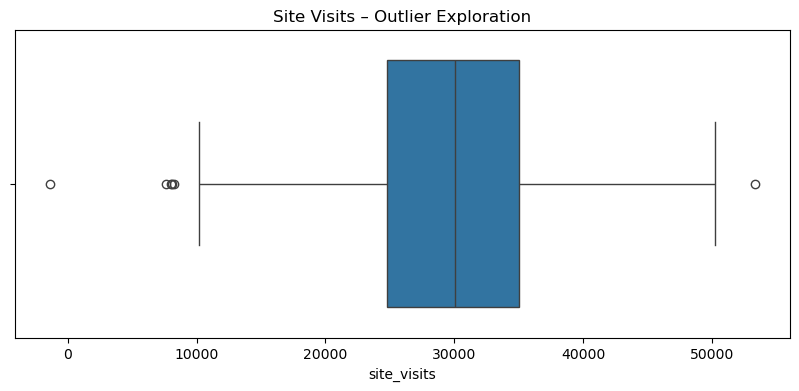

In [29]:
# Site visits outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["site_visits"])
plt.title("Site Visits – Outlier Exploration")
plt.show()

In [30]:
# Site visits distribution data

df["site_visits"].quantile([0.95, 0.99])

0.95    42568.856920
0.99    46688.598835
Name: site_visits, dtype: float64

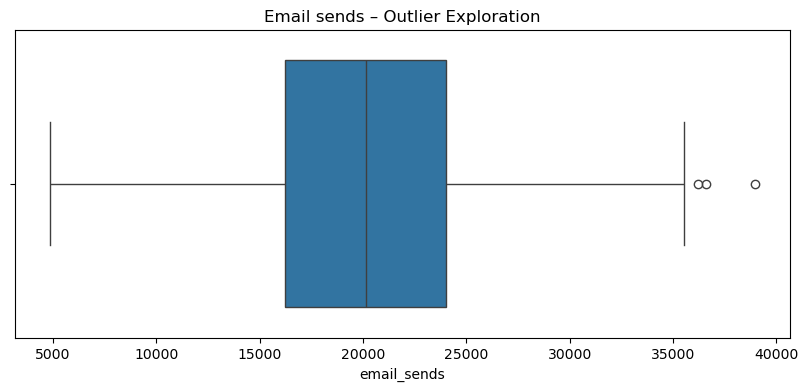

In [31]:
# Emails sends outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["email_sends"])
plt.title("Email sends – Outlier Exploration")
plt.show()

In [32]:
# Emails sends distribution data

df["email_sends"].quantile([0.95, 0.99])

0.95    29770.791868
0.99    33272.090018
Name: email_sends, dtype: float64

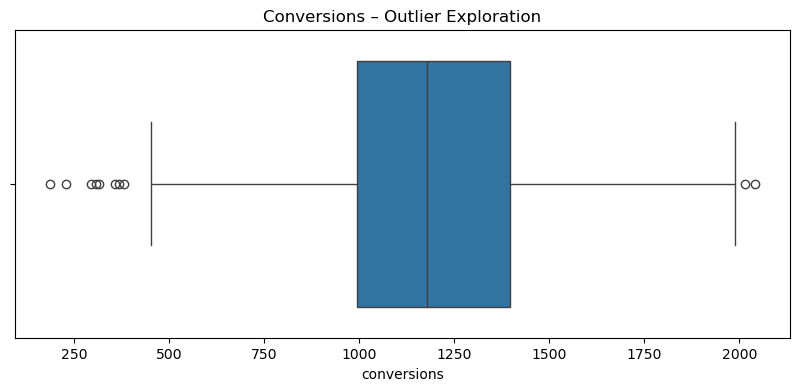

In [33]:
# Conversions outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["conversions"])
plt.title("Conversions – Outlier Exploration")
plt.show()

In [34]:
# Conversions distribution data

df["conversions"].quantile([0.95, 0.99])

0.95    1667.904659
0.99    1842.644268
Name: conversions, dtype: float64

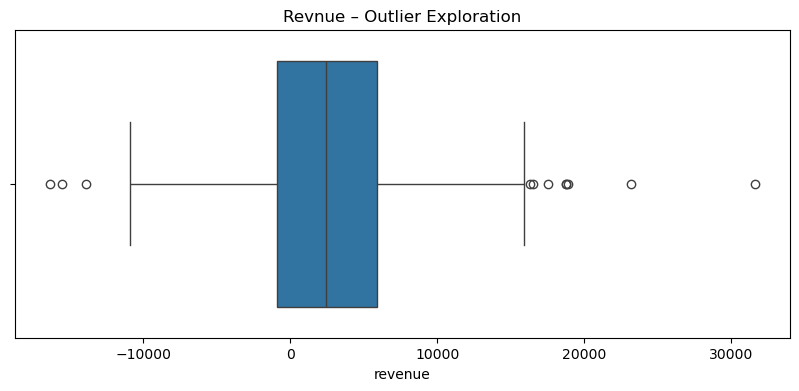

In [35]:
# Revenue outliers

plt.figure(figsize=(10,4))
sns.boxplot(x=df["revenue"])
plt.title("Revnue – Outlier Exploration")
plt.show()

In [36]:
# Revenue distribution data

df["revenue"].quantile([0.95, 0.99])

0.95    10954.973336
0.99    14973.259613
Name: revenue, dtype: float64

Highly skewed spend and volume variables will be log-transformed to stabilize variance and reduce leverage from extreme values. All model inputs will then be robustly scaled using median and IQR to further mitigate residual outlier influence while maintaining interpretability.

## 7. Revenue Relationships

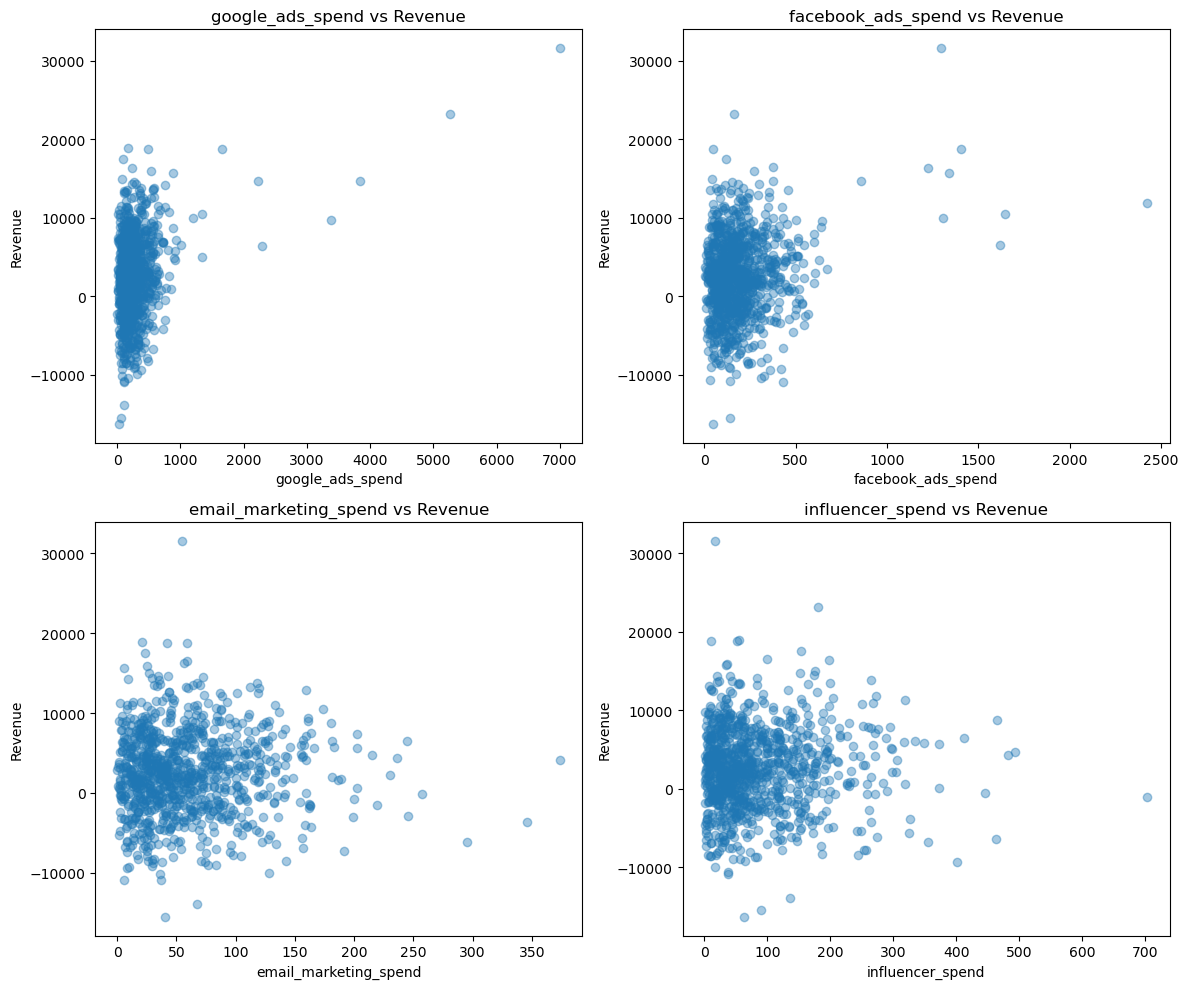

In [12]:
# Spending vs. revenue scatterplots

channels = [
    "google_ads_spend",
    "facebook_ads_spend",
    "email_marketing_spend",
    "influencer_spend"
]

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for ax, col in zip(axes, channels):
    ax.scatter(df[col], df["revenue"], alpha=0.4)
    ax.set_title(f"{col} vs Revenue")
    ax.set_xlabel(col)
    ax.set_ylabel("Revenue")

plt.tight_layout()
plt.show()

## 8. Correlation & Multicollinearity

In [15]:
# Correlation matrix

corr_matrix = df.corr()

# Display correlation matrix as a table
corr_matrix

,date,google_ads_spend,facebook_ads_spend,email_marketing_spend,influencer_spend,organic_traffic,email_sends,site_visits,conversions,revenue
date,1.000000,0.032414,0.063015,-0.052863,0.017441,0.016626,-0.037469,-0.010808,0.001002,-0.008830
google_ads_spend,0.032414,1.000000,0.280433,0.003735,0.041805,0.021639,-0.010625,-0.019962,0.077261,0.311921
facebook_ads_spend,0.063015,0.280433,1.000000,-0.031539,0.040844,0.040374,-0.021618,0.063099,-0.053191,0.206978
email_marketing_spend,-0.052863,0.003735,-0.031539,1.000000,0.035099,0.016314,-0.011642,-0.000218,0.024462,0.008866
influencer_spend,0.017441,0.041805,0.040844,0.035099,1.000000,0.072961,-0.054656,0.023650,0.062339,0.014139
organic_traffic,0.016626,0.021639,0.040374,0.016314,0.072961,1.000000,0.002791,0.031157,0.019917,0.007068
email_sends,-0.037469,-0.010625,-0.021618,-0.011642,-0.054656,0.002791,1.000000,-0.026128,-0.004067,0.043107
site_visits,-0.010808,-0.019962,0.063099,-0.000218,0.023650,0.031157,-0.026128,1.000000,-0.014920,-0.025390
conversions,0.001002,0.077261,-0.053191,0.024462,0.062339,0.019917,-0.004067,-0.014920,1.000000,0.000649
revenue,-0.008830,0.311921,0.206978,0.008866,0.014139,0.007068,0.043107,-0.025390,0.000649,1.000000


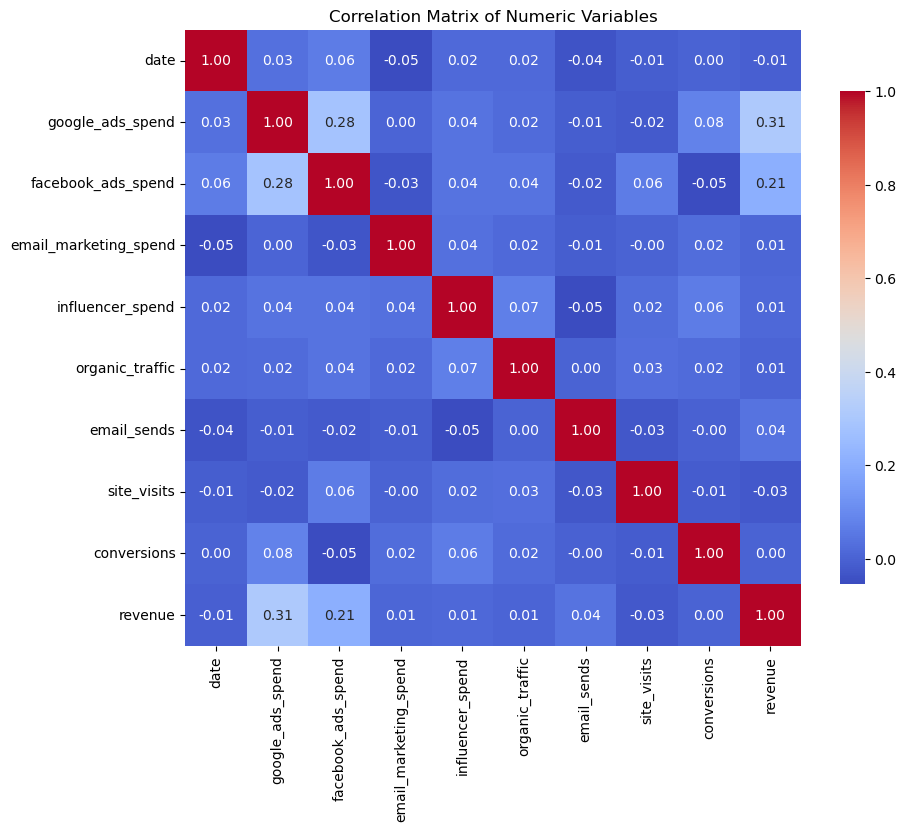

In [16]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,           # show correlation numbers
    fmt=".2f",            # 2 decimal places
    cmap="coolwarm",      # color map
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

## 9. EDA Summary & Next Steps